In [3]:
import json
import pandas as pd
import tensorflow as tf
import tensorflow_text as tf_text
import keras.backend as K
import tensorflow_addons as tfa
import tensorflow_hub as hub
from official.nlp import optimization # # pip install tf-models-official
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import linregress, t
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tqdm
from datasets import Dataset

from sklearn.pipeline import Pipeline
from preprocessing_tools import Normalizer, RatingTransformer
from model_tools import build_model, NumpyEncoder

In [6]:
import os
import json
data = list()
for file in os.listdir("./data"):
    with open("./data/"+file, 'rb') as f:
        print(f"Read {file}")
        data_ = json.load(f)
        data += data_
    

In [9]:
records = [{"Title": record.get('book_title'),
            "Review": record.get('full_comment'),
            "RatingOf5": record.get('stars'),
            } for record in data]
df = pd.DataFrame(records)
df.to_csv("TITLE_REVIEW_RATING.csv")

In [3]:
df = pd.read_csv("TITLE_REVIEW_RATING.csv")

### Data exploration

In [3]:
print("\nTotal # of reviews: ", len(df))
print("\n# of empty records:\n", df.isnull().sum())
print("\n# of unique titles: ", len(df.Title.unique()))
print("\nAverage rating: ", df.RatingOf5.mean())


Total # of reviews:  1734345

# of empty records:
 Title             0
Review       701963
RatingOf5    223274
dtype: int64

# of unique titles:  57982

Average rating:  3.736667568896498


Non-text reviews or reviewss without a rating don't serve much purpose given this is a sentiment NLP task that requires text data and a rating as a label. I'll isolate and drop null records

In [4]:
df[df.Review.isna() == True].sample(5)['Review']

8391      NaN
59844     NaN
854341    NaN
14102     NaN
111632    NaN
Name: Review, dtype: object

In [5]:
df.dropna(inplace=True)

In [7]:
df[df.Review.isna() == True][ 'Review']

Series([], Name: Review, dtype: object)

Given the large size of the data, cutting the review length down will prove very beneficial. First, exploration is needed to ensure this doesn't give rise to bias.

Further exploration into review length and the distribution of reviews shows the reviews are skewed, with lower ratings creating a relatively thin tail. Further, most of the reviews are short. Finally, there is no significant (based on an eyeball estimate) association between the length of reviews and the magnitude of rating. This can be tested using the t-test since we're comparing means.

(3.732681594559398, <AxesSubplot:>)

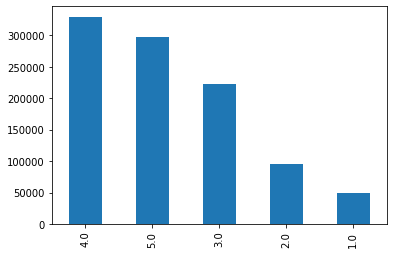

In [8]:
# average review
df.RatingOf5.mean(), df.RatingOf5.value_counts().plot(kind='bar')

<AxesSubplot:ylabel='Frequency'>

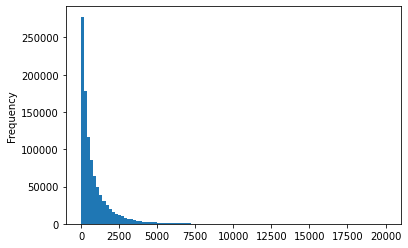

In [9]:
df['Review_length'] = df["Review"].apply(lambda x: len(x))
df['Review_length'].plot(kind='hist', bins = 100)

In [10]:
df.rename(columns={"RatingOf5": "Rating"}, inplace=True), df.columns

(None, Index(['Title', 'Review', 'Rating', 'Review_length'], dtype='object'))

In [11]:
# An eye-ball estiamte shows no real difference between review lengths and rating
df.groupby('Rating').mean()

,Review_length
Rating,
1.0,865.780870
2.0,847.196109
3.0,808.391037
4.0,889.441662
5.0,873.705297


I can use scipy or pingouin to confirm the above hypothesis

In [12]:
# A stastitcal measure like the t-test can provide a more objective judgment
y = df.Rating.values
X = StandardScaler().fit_transform(X=df.Review_length.values.reshape(-1,1)).flatten()
results = linregress(X, y)
results

LinregressResult(slope=0.015635474321477407, intercept=3.732681594559398, rvalue=0.013790745800627455, pvalue=4.551195016363027e-43, stderr=0.0011363987546924386, intercept_stderr=0.0011363987546924414)

In [13]:
lm = pg.linear_regression(X, y, alpha = 0.01)
lm.iloc[1]

names               x1
coef          0.015635
se            0.001136
T            13.758792
pval               0.0
r2             0.00019
adj_r2        0.000189
CI[0.5%]      0.012708
CI[99.5%]     0.018563
Name: 1, dtype: object

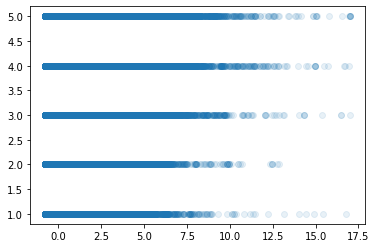

In [14]:
plt.scatter(X,y, alpha=0.1)

Given the significance of the t-stat and insignificance of p-value, there is indeed correlation meaning one cannot simply remove longer reviews. The alternative is yo drop a random sample from the data and test whether the regression metrics are maintained.

(<AxesSubplot:>,)

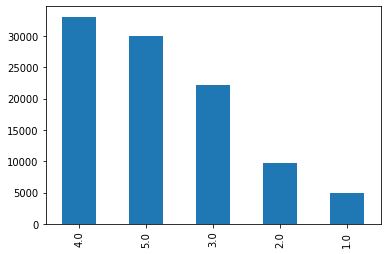

In [15]:
df_new = df.sample(100000)
df_new.Rating.value_counts().plot(kind='bar'), 

<AxesSubplot:ylabel='Frequency'>

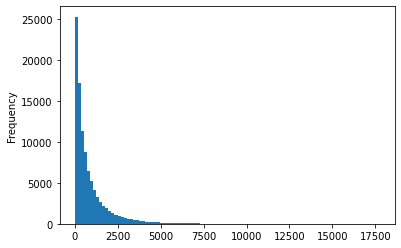

In [16]:
df_new['Review_length'].plot(kind='hist', bins = 100)

In [17]:
y = df_new.Rating.values
X = StandardScaler().fit_transform(X=df_new.Review_length.values.reshape(-1,1)).flatten()

In [18]:
results = linregress(X, y)
results

LinregressResult(slope=0.01447281681853353, intercept=3.7341, rvalue=0.012760436301992339, pvalue=5.452837095436334e-05, stderr=0.0035863818143671974, intercept_stderr=0.0035863818143671983)

In [19]:
lm = pg.linear_regression(X, y, alpha = 0.01)
lm.iloc[1]

names              x1
coef         0.014473
se           0.003586
T            4.035492
pval         0.000055
r2           0.000163
adj_r2       0.000153
CI[0.5%]     0.005235
CI[99.5%]    0.023711
Name: 1, dtype: object

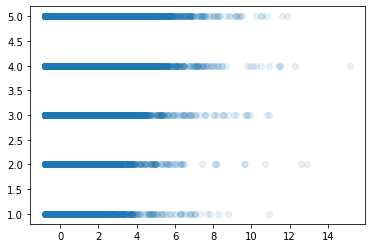

In [20]:
plt.scatter(X,y, alpha=0.1)

Thus I've reduced the data size to 100K reviews while 'generally' maintaing the distribution of length to rating magnitude and core regression metrics.

In [45]:
df_new.to_csv('Raw_text_data.csv', index=False)

### Data normalization

In [235]:
df = pd.read_csv('Raw_text_data.csv')

In [35]:
# TF BERTs feature a preprocessing layer, but I want to ensure the punctutaion and lower casing is done per 

from sklearn.base import BaseEstimator, TransformerMixin



class Normalizer(BaseEstimator, TransformerMixin):
    def fit(self, X: pd.DataFrame, y: pd.DataFrame=None, ):
        return self
    
    def normalize(self, text: str) -> str:
        '''
        Normalizes a single string; no tokenization applied!!
        This function will 'detensorify' strings to be 'retensored'
        later when created tensorflow from_tensor_slices.
        '''
        text = tf_text.normalize_utf8(text, 'NFKD')
        text = tf.strings.lower(text)
        text = tf.strings.regex_replace(text, '[^ a-z]', '')
        text = tf.strings.strip(text).numpy().decode()
        return text
    
    def transform(self, data):
        new_data = data.copy()
        new_data['Review'] = new_data['Review'].apply(self.normalize)
        
        return new_data

In [39]:
df = Normalizer().fit_transform(df)

In [40]:
df['Review_length'] = df["Review"].apply(lambda x: len(x))

In [41]:
# A significantnumber of long review are lost
sorted(df_before['Review_length'] - df['Review_length'])[::-1][:10]

[19837, 11241, 7593, 7574, 7455, 7164, 6856, 6120, 6073, 5779]

In [42]:
# 586 total reviews were lost and feature letters in Hebrew, Arabic, Greek, etc.
len(df_before[df['Review_length'] == 0])

586

In [43]:
# dropping the resulting zero-length reviews

df.drop(index=df[df['Review_length'] == 0].index, inplace = True)
df[df['Review_length'] == 0]

,Title,Review,Rating,Review_length


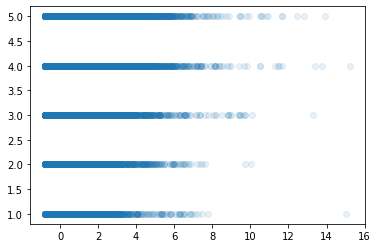

In [44]:
from sklearn.preprocessing import StandardScaler
y = df.Rating.values
X = StandardScaler().fit_transform(X=df.Review_length.values.reshape(-1,1)).flatten()
plt.scatter(X,y, alpha=0.1)

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin
class RatingTransformer(BaseEstimator, TransformerMixin):
    def fit(self, y: pd.DataFrame, X: pd.DataFrame=None, ):
        return self
    
    def transform(self, data):
        new_data = data.copy()
        new_data.loc[new_data['Rating'] >= 4, 'Label'] = 2
        new_data.loc[new_data['Rating'] == 3, 'Label'] = 1
        new_data.loc[new_data['Rating'] <=2, 'Label'] = 0
        return new_data


In [50]:
transformed = RatingTransformer().fit_transform(df)
transformed.head()[['Title', 'Rating', 'Label']]

,Title,Rating,Label
0,The Seat of the Soul,5.0,2.0
1,Confessions of a Sociopathic Social Climber: T...,1.0,0.0
3,Vengeance Is Mine Desire No 493,3.0,1.0
4,The Western Guide to Feng ShuiRoom by Room,3.0,1.0
5,The Nightrunners,2.0,0.0


In [51]:
transformed[['Review', 'Label']].to_csv('data_before_train_test_split.csv', index=False)

In [52]:
from sklearn.model_selection import train_test_split

X, y= transformed['Review'], transformed['Label']
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    stratify=y, 
                                                    test_size = 0.2) 


In [53]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((79531,), (79531,), (19883,), (19883,))

In [54]:
y_train, y_test = tf.one_hot(y_train, 3), tf.one_hot(y_test, 3)
y_train.shape, y_test.shape

(TensorShape([79531, 3]), TensorShape([19883, 3]))

In [55]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(SHUFFLE_BUFFER_SIZE//2).batch(BATCH_SIZE)

In [58]:
# View a sample review from a batch and its label
for i in train_dataset.take(1):
    print("Review: ", i[0][0].numpy(), "\nLabel: ", i[1][0].numpy())
    break    

In [76]:
from bert_mapping import map_name_to_handle, map_model_to_preprocess

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-256_A-4' # change to desired configuration

tfhub_handle_encoder = map_name_to_handle[bert_model_name] # map to chosen encoder configuration
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name] # map to chosen preprocessor configuration

In [96]:
def build_model(tfhub_handle_preprocess, tfhub_handle_encoder):
    '''
    This function builds a text classifier model
    '''
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='Reviews') # takes on any shape input
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, 
                                         name='Preporcessing') # BERT preprocessing layer
    
    encoder_inputs = preprocessing_layer(text_input) # BERT encoding layer
    encoder = hub.KerasLayer(tfhub_handle_encoder, 
                             trainable=True, name='Encoding')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output'] # using pooled output since it is sufficient for predictive purposes

    # Where actual classifier layers start
    net = tf.keras.layers.Dropout(0.1)(net) # dropout optimal at 0.1, anything more or less overfits
    # Add dense layers as required. For optimal model, no intermediate dense layers are added
    net = tf.keras.layers.Dense(3, activation="softmax", name='Classifier')(net) # only one dense output layer is optimal, any other layers overfit
    return tf.keras.Model(text_input, net)


loss= tf.keras.losses.CategoricalCrossentropy()
metrics = [
           tfa.metrics.F1Score(average='weighted', num_classes=3, name="Weighted-F1"),
           tf.keras.metrics.AUC(num_thresholds=5, name = "Area_under_the_curve"),
           tf.keras.metrics.BinaryAccuracy()
           ]


def compile_model(epochs = 5, train_dataset = train_dataset, lr = 3e-5)

    epochs = epochs
    steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
    num_train_steps = steps_per_epoch * epochs
    # warm up steps help reduce large effects of the initial few training instances
    num_warmup_steps = int(0.1*num_train_steps) 

    init_lr = lr
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              # adamw uses a regularization parameter making it better than adam
                                              optimizer_type='adamw')

# instantiate compile
    classifier_model = build_model()

# compile model
    classifier_model.compile(optimizer=optimizer,
                             loss=loss,
                             metrics=metrics)
    return classifier_model

classifier_model = classifier_model()
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Reviews (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 Preporcessing (KerasLayer)     {'input_type_ids':   0           ['Reviews[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [1]:
EPOCHS = 5
classifier_model.fit(train_dataset, validation_data=test_dataset, epochs=EPOCHS, batch_size=264)

In [ ]:
tf.keras.models.save_model(classifier_model, 'classifier_model')

In [61]:
loaded = tf.keras.models.load_model("classifier_model", 
                                    custom_objects={'KerasLayer':hub.KerasLayer , 'AdamWeightDecay': optimizer})

In [237]:
eval_metrics = loaded.evaluate(test_dataset)

In [236]:
for i, j in zip(loaded.metrics_names, eval_metrics):
    print(f"Validation {i}: {j}")

In [63]:
labels = {0: "Negative", 1: "Neutral", 2: "Positive"}

Predict the sentiment on some made-up reviews

In [64]:
prediction = loaded.predict(['This book was not what I was expecting but it had good plot twists.'])
labels[prediction.argmax()]

'Neutral'

In [65]:
prediction2 = loaded.predict(['Plot developement was underwhelming. The author could have done better.'])
labels[prediction2.argmax()]

'Negative'

In [66]:
prediction3 = loaded.predict(['The author displays great mastery over character composition. Still there is room for improvement'])
labels[prediction3.argmax()]

'Positive'

### Text Summarization and Label Propagation


Review sentiment doesn't exactly user rating in that:
1. The review sentiment reflects the content of the review, so a review for a book or movie about tragedy may imply negative sentiment but may receive a high rating such as a 4/5 or 5/5
2. A review that talks about a plot with a "good ending" may not nevessarily feature a high user rating but instead may feature a rating or 1/5 or 2/5 given the poor quality of authorship;

Given this, it is not only necessary to reuse the ~ 540K records that I've discarded due to their lenght, but it's also necessary to try a pretrained sentence transformer to propagate labels for the review. 

I'll begin by reloadin the full dataset, conducting the transformation as well as adding a text summarization step, and a label propagation step through the use of HuggingFace's transformers and datasets libraries.

In [2]:
df = pd.read_csv("TITLE_REVIEW_RATING.csv")  # TODO: train data file name to config

# Drop empty reviews/ ratings since they serve no purpose
df.dropna(inplace=True)

# limit GPU memory allocation by tf text
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.1)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

# run tokenization/ label encoding pipeline
pipeline = Pipeline([
    ('Normalize', Normalizer()),
    ('LabelTransform', RatingTransformer(review_col='RatingOf5'))])
df = pipeline.fit_transform(df)
df.drop(columns='temp_col', inplace=True)

In [3]:
df['WordCount'] = df['Review'].apply(lambda x: len(x.split()))
# Drop empty reviews resulting from normalization
df.drop(index=df[df['WordCount'] == 0].index, inplace=True)
df.drop(index=df[df['WordCount'] > 400].index, inplace=True)

long_reviews = df[df['WordCount'] > 100]
df.drop(index=df[df['WordCount'] > 100].index, inplace=True)

original_sentences = list(long_reviews['Review'])
user_ratings = list(long_reviews['RatingOf5'])
all_long_reviews = Dataset.from_pandas(long_reviews[['Review']])
to_summarize = Dataset.from_pandas(long_reviews[['Review']][:1000])

In [4]:
all_long_reviews = all_long_reviews.remove_columns('__index_level_0__')

# take a sample
to_summarize = to_summarize.remove_columns('__index_level_0__')
to_summarize

Dataset({
    features: ['Review'],
    num_rows: 1000
})

In [5]:
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm

config = {'max_length': 50, 'min_length': 5, 'batch_size': 16}
def summarize(corpus, device):    
    nlp = pipeline("summarization", model='philschmid/bart-large-cnn-samsum', device=device)
    lst_summaries = [out for out in tqdm(nlp(KeyDataset(corpus, "Review"), **config))]
    return lst_summaries
# for i, j in zip(original_sentences, predicted):
#     print("\n\nOriginal: ", i, "\n\nSummarized: ", j[0]['summary_text'])

In [8]:
summarized = summarize(corpus=all_long_reviews,device=0) # summarizing all 421,723 records

In [2]:
summarized = summarize(corpus=to_summarize,device=0)

Given processor limitation (in my case, it's a 12gb 3060), it'll take me a long time to summarize 500K records in maximum batch size of 16, I will demonstrate that summarization of the longer reviews is less than ideal as contextual elements for sentiment analysis are often eliminated. 

Instead, I propose sentence by sentence, or every-other-sentence, or begginign-middle-and-end text summary. That splits a review into a list of strings and takes odd/even elements, or takes a couple of sentences from the beginning, end and middle, or takes sentences at the begginning of each paragraph for those review that contain a line character ```\n```.

### Label propagation

In [6]:
df['WordCount'] = df['Review'].apply(lambda x: len(x.split()))

# Drop empty reviews resulting from normalization
df.drop(index=df[df['WordCount'] == 0].index, inplace=True)

# Drop long reviews due to network being able to handle only 1024-toekn sequences
df.drop(index=df[df['WordCount'] > 800].index, inplace=True)

In [25]:
df = pd.read_csv('data_for_label_propagate.csv')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972667 entries, 0 to 972666
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Title      972667 non-null  object 
 1   Review     972665 non-null  object 
 2   RatingOf5  972667 non-null  float64
 3   Label      972667 non-null  float64
 4   WordCount  972667 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 37.1+ MB


In [28]:
df = df.astype('str')

In [4]:
assert all([isinstance(df['Review'][i], str) for i in range(len(df))])

In [5]:
to_propagate = Dataset.from_pandas(df[['Review']])
to_propagate

Dataset({
    features: ['Review'],
    num_rows: 972667
})

In [6]:
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset

sentiment_analysis = pipeline("text-classification", model='distilbert-base-uncased-finetuned-sst-2-english', batch_size=256, device=0)
prediction = [out for out in sentiment_analysis(KeyDataset(to_propagate, "Review"), truncation="only_first")]

In [19]:
df['PropLabel'] = [1 if prediction[i]['label'] == 'POSITIVE' else -1 for i in range(len(df))]
print(sum([1 if prediction[i]['label'] == 'POSITIVE' else -1 for i in range(len(df))]) 
    == sum(df2['PropLabel']))

True


In [30]:
pd.set_option('max_colwidth', 2000)
df2[['Review', 'PropLabel']]

### Training pipeline


For training labelled data

In [7]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_text as tf_text
import keras.backend as K
import tensorflow_addons as tfa
import tensorflow_hub as hub
from official.nlp import optimization
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from preprocessing_tools import Normalizer, RatingTransformer
from model_tools import build_model, NumpyEncoder

In [10]:
df = pd.read_csv("TITLE_REVIEW_RATING.csv")  # TODO: train data file name to config

In [13]:
df['Review_length'] = df["Review"].apply(lambda x: len(x))
df.drop(index=df[df['Review_length'] > 400].index, inplace=True)
df.dropna(inplace=True)

In [ ]:
pipeline = Pipeline([
    ('Normalize', Normalizer()),
    ('LabelTransform', RatingTransformer(review_col='RatingOf5'))])

In [7]:
df.sample(150000).to_csv('train_v04_17_2022.csv', index=False)

In [15]:
df = pipeline.fit_transform(df)

In [16]:
df.drop(index=df[df['Review_length'] == 0].index, inplace=True)

In [13]:
index = df.sample(20).index
df_to_test = df_.drop(index=df_[df_.index.isin(index)].index)

Train-test splits

In [35]:
# Train-test splot
X, y= df['Review'], df['Label']
x_train, x_val, y_train, y_val = train_test_split(X, 
                                                    y,
                                                    stratify=y, 
                                                    test_size = 0.2)
y_train, y_val = tf.one_hot(y_train, 3), tf.one_hot(y_val, 3)

In [176]:
df_to_test = df_to_test.sample(20000)
x_test, y_test = df_to_test['Review'], df_to_test['Label']
y_test = tf.one_hot(y_test, 3)

In [1]:
idx = 0
for i, j, k in zip(original_sentences, prediciton, user_ratings):
    print("\n\n", i, j['label'], k, "\n\n")
    idx+=1

In [177]:
# prepare data for compatibility with tensorflow nn
BATCH_SIZE = 32 # TODO: config
SHUFFLE_BUFFER_SIZE = 32  # TODO: config
EPOCHS = 3  # TODO: config
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(SHUFFLE_BUFFER_SIZE//2).batch(BATCH_SIZE)

In [178]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [153]:
# setup model
classifier_model, optimizer = build_model(
    train_dataset=train_dataset,
    epochs=EPOCHS)
type(classifier_model)
# classifier_model.summary()

keras.engine.functional.Functional

In [182]:
json.dump(optimizer.get_config(), open('opt_config.json', 'w'), cls=NumpyEncoder)

In [156]:
# fit model
classifier_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

In [238]:
# evaluate model
test_metrics = classifier_model.evaluate(test_dataset)

In [157]:
# save/load model
tf.keras.models.save_model(classifier_model, 'classifier_model')

INFO:tensorflow:Assets written to: classifier_model_\assets


INFO:tensorflow:Assets written to: classifier_model_\assets


#### Transfer Learning: Sentence Transformers Pipeline

In [71]:
import spacy
import spacy_transformers
import spacy_sentence_bert
from sentence_transformers import SentenceTransformer

In [112]:
train_reviews = X.to_list()
train_labels = np.array(y)
model = SentenceTransformer('all-distilroberta-v1', device='cuda')
# Others architechtures that we've tested: 'all-distilroberta-v1', 
# 'all-mpnet-base-v2', 'all-MiniLM-L12-v2', 'all-MiniLM-L6-v2'

In [114]:
sentence_embeddings = model.encode(train_reviews)
shape = (sentence_embeddings.shape)[1]

In [115]:
from numpy import save
save('under100_all-distilroberta-v1_sentence_embeddings', sentence_embeddings)

In [116]:
sentence_embeddings.shape

(450722, 768)

In [117]:
x=sentence_embeddings
y=train_labels
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    shuffle=True, 
                                                    stratify=y)

y_train, y_test = tf.one_hot(y_train, 3), tf.one_hot(y_test, 3)
# setup train/test datasets for classification
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 256

train_data = train_data.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_data = test_data.shuffle(SHUFFLE_BUFFER_SIZE//2).batch(BATCH_SIZE)

In [121]:
def build_classifier_model_st():
    '''
    Basic classification layers that takes in shape equal to the defined encoding size of SBERT
    '''
    text_input = tf.keras.layers.Input(shape=shape, name='Reviews')
    net = tf.keras.layers.Dropout(0.1)(text_input)
    # Add dense layers as necessary
#     net = tf.keras.layers.Dense(512, activation="relu", name='Dense1')(net)
#     net = tf.keras.layers.Dropout(0.1)(net)
#     net = tf.keras.layers.Dense(256, activation="relu", name='Dense2')(net)
#     net = tf.keras.layers.Dropout(0.1)(net)
#     net = tf.keras.layers.Dense(128, activation="relu", name='Dense3')(net)
#     net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(64, activation="relu", name='Dense4')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(32, activation="relu", name='Dense5')(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name='Classifier')(net) 
    return tf.keras.Model(text_input, net)


metrics = [
            tfa.metrics.F1Score(average='weighted', num_classes=3, name="Weighted-F1"),
            tf.keras.metrics.AUC(),
            tf.keras.metrics.CategoricalAccuracy()
          ]
loss= tf.keras.losses.CategoricalCrossentropy()

EPOCHS = 10
steps_per_epoch = tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * EPOCHS
# warm up steps help reduce large effects of the initial few training instances
num_warmup_steps = int(0.1*num_train_steps) 

# Learning rates: optinal and stable at 0.004/0.005, anything above or below has either not converged or was too unstable during training 
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          # adamw uses a regularization parameter making it better than adam
                                          optimizer_type='adamw')

classifier_model_st = build_classifier_model_st()

# compile model
classifier_model_st.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics) 

In [122]:
classifier_model_st.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Reviews (InputLayer)        [(None, 768)]             0         
                                                                 
 dropout_55 (Dropout)        (None, 768)               0         
                                                                 
 Dense4 (Dense)              (None, 64)                49216     
                                                                 
 dropout_56 (Dropout)        (None, 64)                0         
                                                                 
 Dense5 (Dense)              (None, 32)                2080      
                                                                 
 Classifier (Dense)          (None, 3)                 99        
                                                                 
Total params: 51,395
Trainable params: 51,395
Non-trainabl

In [234]:
classifier_model_st.fit(train_data, 
                        batch_size=BATCH_SIZE, 
                        epochs=EPOCHS, 
                        validation_data=tes_data)

In [ ]:
classifier_model_st.evaluate(test_data)

### Inference pipeline

In [183]:
# load model
optimizer = optimization.create_optimizer(init_lr=None,
    num_train_steps=None,
    num_warmup_steps=None).from_config(json.load(open('opt_config.json', 'r')))

loaded = tf.keras.models.load_model("classifier_model_", 
                                    custom_objects={'KerasLayer':hub.KerasLayer, 
                                                    'AdamWeightDecay': optimizer})

In [203]:
# # predict
labels = {0: "Negative", 1: "Neutral", 2: "Positive"} # TODO: config
labels[loaded.predict([[i[0].numpy() for i in test_dataset.take(1)][0][1]]).argmax()], 

'Positive'

In [209]:
labels[(
    loaded.predict(["This book doesn't have the most exciting characters; plot development was poor"]).argmax())]

'Negative'

In [207]:
labels[(
    loaded.predict(["This book doesn't have the most exciting characters; plot development wasn't good either"]).argmax())]

'Neutral'

When doing inference using the model, the model seems to capture pecularities about the style of the comment such as the difference between 'was poor' (classified as negative) and 'wasn't good' (classfied as neutral). Still, a lot more testing is required to confirm whether the validation and test metrics really hold up since it is notoriously difficult to train classifiers on long sentences such as this dataset which comprised of comments that were on average 30-70 words (400 characters).